In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

In [0]:
path = 'drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv')
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv')
test1_trade = pd.read_csv('data/test/test1_trade.csv')

# test2_activity = pd.read_csv(path + 'test/test2_activity.csv')
# test2_combat = pd.read_csv(path + 'test/test2_combat.csv')
# test2_payment = pd.read_csv(path + 'test/test2_payment.csv')
# test2_pledge = pd.read_csv(path + 'test/test2_pledge.csv')
# test2_trade = pd.read_csv(path + 'test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')
train_label['total_spent'] = train_label['survival_time']*train_label['amount_spent']
train_label['adjust_survival_time'] = train_label['survival_time']
train_label.loc[train_label['adjust_survival_time']<64, 'adjust_survival_time'] = 1
train_label.loc[train_label['adjust_survival_time']==64, 'adjust_survival_time'] = 0
train_label = pd.merge(train_activity[['acc_id', 'char_id']], train_label, how='left', on='acc_id')

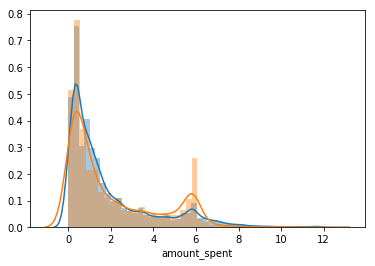

In [0]:
sns.distplot(train_payment.groupby('acc_id')['amount_spent'].sum())

sns.distplot(test1_payment.groupby('acc_id')['amount_spent'].sum())

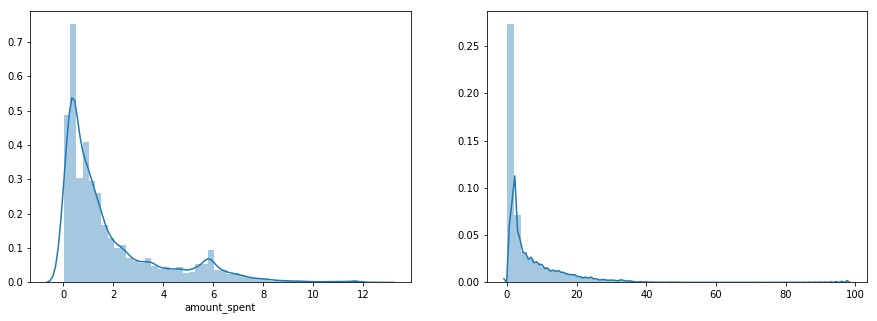

In [0]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train_payment.groupby('acc_id')['amount_spent'].sum())
plt.subplot(1, 2, 2)
sns.distplot(train_label['amount_spent']*train_label['survival_time'])

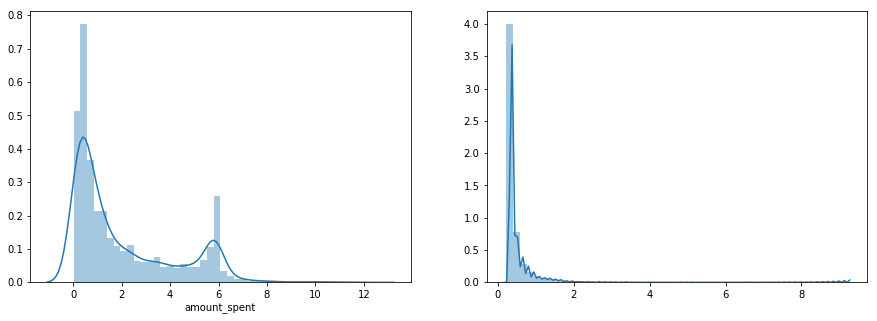

In [0]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(test1_payment.groupby('acc_id')['amount_spent'].sum())
plt.subplot(1, 2, 2)
sns.distplot(preds2)

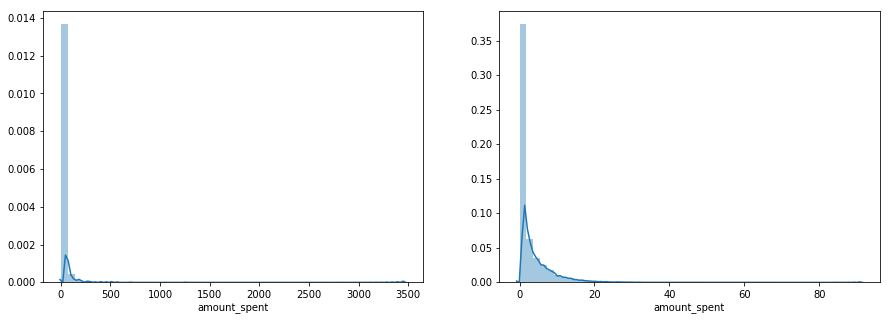

In [0]:
heavy_label = train_label.loc[train_label['amount_spent']>0.3, 'acc_id'].drop_duplicates()
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train_label.groupby('acc_id')['amount_spent'].sum().reset_index()[train_label.groupby('acc_id')['amount_spent'].sum().reset_index()['acc_id'].isin(heavy_label)]['amount_spent'])
plt.subplot(1, 2, 2)
sns.distplot(train_label.groupby('acc_id')['amount_spent'].sum().reset_index()[~train_label.groupby('acc_id')['amount_spent'].sum().reset_index()['acc_id'].isin(heavy_label)]['amount_spent'])

In [0]:
def feature_extraction(train, data, feature, method, week):
    '''
    data - DataFrame
    feature - column name
    metod - ex) sum, unique, min, max ...etc
    '''
    if week==1:
        data = data[(data['day']>0) & (data['day']<8)]
    elif week==2:
        data = data[(data['day']>7) & (data['day']<15)]
    elif week==3:
        data = data[(data['day']>14) & (data['day']<22)]
    else:
        data = data[(data['day']>21) & (data['day']<29)]
    
    
    standard_feature = 'acc_id'
    if method=='nunique':
        data = data.groupby(standard_feature)[feature].nunique().reset_index()
    elif method=='sum':
        data = data.groupby(standard_feature)[feature].sum().reset_index()
    elif method=='min':
        data = data.groupby(standard_feature)[feature].min().reset_index()
    elif method=='max':
        data = data.groupby(standard_feature)[feature].max().reset_index()
    elif method=='mean':
        data = data.groupby(standard_feature)[feature].mean().reset_index()
    elif method=='median':
        data = data.groupby(standard_feature)[feature].median().reset_index()
    elif method=='skew':
        data = data.groupby(standard_feature)[feature].skew().reset_index()
    elif method=='kurt':
        data = data.groupby(standard_feature)[feature].kurt().reset_index()
    elif method=='size':
        data = data.groupby(standard_feature)[feature].size().reset_index()
    else:
        return print('method is no return')
    
    
    train = pd.merge(train, data, how='left', on='acc_id')
    
    return train

In [0]:
train = pd.DataFrame(np.unique(train_label['acc_id']), columns=['acc_id'])

## Activity

In [0]:
DATA = train_activity
ON = 'acc_id'

for WEEK in tqdm(range(1, 5)):
    
    train = feature_extraction(train, data=DATA, feature='char_id', method='nunique', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='server', method='nunique', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='playtime', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='playtime', method='max', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='playtime', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='playtime', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='playtime', method='median', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='npc_kill', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='npc_kill', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='npc_kill', method='median', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='solo_exp', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='solo_exp', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='solo_exp', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='solo_exp', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='solo_exp', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='party_exp', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='party_exp', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='party_exp', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='party_exp', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='party_exp', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='quest_exp', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='quest_exp', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='quest_exp', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='quest_exp', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='quest_exp', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='rich_monster', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='rich_monster', method='size', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='death', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='death', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='death', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='death', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='death', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='revive', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='revive', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='revive', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='revive', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='revive', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='exp_recovery', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='exp_recovery', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='exp_recovery', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='exp_recovery', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='exp_recovery', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='fishing', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='fishing', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='fishing', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='fishing', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='fishing', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='private_shop', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='private_shop', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='private_shop', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='private_shop', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='private_shop', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='game_money_change', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='game_money_change', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='game_money_change', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='game_money_change', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='game_money_change', method='max', week=WEEK)
    
    train = feature_extraction(train, data=DATA, feature='enchant_count', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='enchant_count', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='enchant_count', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='enchant_count', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='enchant_count', method='max', week=WEEK)

100%|██████████| 4/4 [00:34<00:00,  8.71s/it]


## Payment

In [0]:
DATA = train_payment
ON = 'acc_id'

for WEEK in tqdm(range(1, 5)):
    
    train = feature_extraction(train, data=DATA, feature='amount_spent', method='min', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='amount_spent', method='max', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='amount_spent', method='sum', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='amount_spent', method='mean', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='amount_spent', method='median', week=WEEK)
    train = feature_extraction(train, data=DATA, feature='amount_spent', method='skew', week=WEEK)

100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


In [0]:
train = train.fillna(-99)
colname = ['acc_id']
temp_colname = ['activity_col' + str(i) for i in range(1, train.shape[1])]
colname.extend(temp_colname)

train.columns = colname

In [0]:
test1 = test1.fillna(-99)
colname = ['acc_id']
temp_colname = ['activity_col' + str(i) for i in range(1, test1.shape[1])]
colname.extend(temp_colname)

test1.columns = colname

In [0]:
SEED=42
LABEL='survival_time'
data = pd.merge(train, train_label[[LABEL, 'acc_id']].drop_duplicates(), how='left', on='acc_id')
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(data.drop(columns=['acc_id', LABEL]), data[LABEL])
preds = rf.predict(test1.drop(columns=['acc_id']))

In [0]:
SEED=42
LABEL='amount_spent'
data = pd.merge(train, train_label[[LABEL, 'acc_id']].drop_duplicates(), how='left', on='acc_id')
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(data.drop(columns=['acc_id', LABEL]), data[LABEL])
preds2 = rf.predict(test1.drop(columns=['acc_id']))

In [0]:
pred1 = pd.concat([pd.concat([test1['acc_id'], pd.DataFrame(preds, columns=['survival_time'])], 1), pd.DataFrame(preds2, columns=['amount_spent'])], 1)
pred1.to_csv('/content/predcit.csv', index=False)

In [0]:
train = train.fillna(-99)
colname = ['acc_id']
temp_colname = ['activity_col' + str(i) for i in range(1, train.shape[1])]
colname.extend(temp_colname)
train.columns = colname
heavy_label = train_label.loc[train_label['amount_spent']>0.15, 'acc_id'].drop_duplicates()


test1 = test1.fillna(-99)
colname = ['acc_id']
temp_colname = ['activity_col' + str(i) for i in range(1, test1.shape[1])]
colname.extend(temp_colname)

test1.columns = colname

In [0]:
heavy_label = train_label.loc[train_label['amount_spent']>0.3, 'acc_id'].drop_duplicates()

In [0]:
seed=42
LABEL='survival_time'
data = pd.merge(train, train_label[[LABEL, 'acc_id']].drop_duplicates(), how='left', on='acc_id')

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=SEED, shuffle=True, stratify=data[LABEL])


params = {
    'objective':'multiclass',
    'num_class':64,
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':seed
}

trn_label = data.loc[train_df.index, LABEL] - 1
val_label = data.loc[valid_df.index, LABEL] - 1

ttt = lgb.Dataset(data.loc[train_df.index, temp_colname], label=trn_label)
vvv = lgb.Dataset(data.loc[valid_df.index, temp_colname], label=val_label)

lgb_model = lgb.train(params, ttt, 5000, valid_sets = [ttt, vvv], early_stopping_rounds = 25, verbose_eval=50)
preds = lgb_model.predict(test1[temp_colname])
preds = np.argmax(preds, axis=1)+1

Training until validation scores don't improve for 25 rounds.
[50]	training's multi_logloss: 1.48932	valid_1's multi_logloss: 1.99157
[100]	training's multi_logloss: 1.10728	valid_1's multi_logloss: 1.90592
[150]	training's multi_logloss: 0.869898	valid_1's multi_logloss: 1.8784
[200]	training's multi_logloss: 0.704835	valid_1's multi_logloss: 1.87108
Early stopping, best iteration is:
[199]	training's multi_logloss: 0.707634	valid_1's multi_logloss: 1.8709


In [0]:
np.bincount(preds)

array([    0,  1742,    88,   115,    16,     1,     3,     0,   106,
           1,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,   271,     0,     0,     0,     0,     0,     0,
         112,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0, 17545])

In [0]:
seed=42
LABEL='amount_spent'
data = pd.merge(train, train_label[[LABEL, 'acc_id']].drop_duplicates(), how='left', on='acc_id')

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=SEED, shuffle=True)
    
params = {
    'objective':'regression',
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'metrics':'mse',
    'seed':seed
}

trn_label = data.loc[train_df.index, LABEL]
val_label = data.loc[valid_df.index, LABEL]

heavy_index = train_df[train_df['acc_id'].isin(heavy_label)].index
for i in range(3):
    train_df = pd.concat([train_df, train_df.loc[heavy_index]])
    trn_label = pd.concat([trn_label, trn_label.loc[heavy_index]])


ttt = lgb.Dataset(data.loc[train_df.index, temp_colname], label=trn_label)
vvv = lgb.Dataset(data.loc[valid_df.index, temp_colname], label=val_label)

lgb_model = lgb.train(params, ttt, 5000, valid_sets = [ttt, vvv], early_stopping_rounds = 100, verbose_eval=500)
preds2 = lgb_model.predict(test1[temp_colname])

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[35]	training's l2: 1.30111	valid_1's l2: 0.564047


In [0]:
pd.DataFrame(preds2).to_csv('/content/to.csv', index=False)

In [0]:
pred1 = pd.concat([pd.concat([test1['acc_id'], pd.DataFrame(preds, columns=['survival_time'])], 1), pd.DataFrame(preds2, columns=['amount_spent'])], 1)
pred1.to_csv('/content/predcit.csv', index=False)

## Combat

In [0]:
DATA = train_combat
train = pd.merge(train, feature_extraction(data=DATA, feature='char_id', method='nunique'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='server', method='nunique'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='class', method='nunique'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='level', method='nunique'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='level', method='sum'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='pledge_cnt', method='sum'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='random_attacker_cnt', method='sum'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='random_defender_cnt', method='sum'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='temp_cnt', method='sum'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='same_pledge_cnt', method='sum'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='etc_cnt', method='sum'), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='num_opponent', method='sum'), how='left', on=ON)

## Payment

In [0]:
train['acc_id'] = train['custom_acc_id'].apply(lambda x: x.split('_')[0]).astype(int)
ON = 'acc_id'
DATA = train_payment
train = pd.merge(train, feature_extraction(data=DATA, feature='day', method='nunique', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='day', method='size', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='amount_spent', method='nunique', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='amount_spent', method='sum', on=ON), how='left', on=ON)

## Pledge

In [0]:
DATA = train_pledge
ON = 'custom_acc_id'
train = pd.merge(train, feature_extraction(data=DATA, feature='char_id', method='nunique', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='server', method='nunique', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='pledge_id', method='nunique', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='play_char_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='play_char_cnt', method='size', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='combat_char_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='pledge_combat_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='random_attacker_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='random_defender_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='same_pledge_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='temp_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='etc_cnt', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='combat_play_time', method='sum', on=ON), how='left', on=ON)
train = pd.merge(train, feature_extraction(data=DATA, feature='non_combat_play_time', method='sum', on=ON), how='left', on=ON)

## Trade

In [0]:
DATA = train_trade
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='time', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='type', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='server', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='type', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='source_char_id', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='target_acc_id', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='target_char_id', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_type', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_amount', method='sum'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_amount', method='min'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_amount', method='max'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_amount', method='mean'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_price', method='sum'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_price', method='min'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_price', method='max'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'source_acc_id':'acc_id'}), feature='item_price', method='mean'), how='left', on='acc_id')

train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='time', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='type', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='server', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='type', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='source_acc_id', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='source_char_id', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='target_char_id', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_type', method='nunique'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_amount', method='sum'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_amount', method='min'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_amount', method='max'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_amount', method='mean'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_price', method='sum'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_price', method='min'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_price', method='max'), how='left', on='acc_id')
train = pd.merge(train, feature_extraction(data=DATA.rename(columns={'target_acc_id':'acc_id'}), feature='item_price', method='mean'), how='left', on='acc_id')

## Model

In [0]:
def lgb_model(train, valid, train_label, test, seed=42, label=None):
    if label=='adjust_survival_time':
        trn_label = train_label.loc[train.index]
        val_label = train_label.loc[valid.index]
                
        rf = RandomForestClassifier().fit(train.drop(columns='custom_acc_id'), trn_label)
        preds = rf.predict(valid.drop(columns='custom_acc_id'))

    elif label=='survival_time':
        trn_label = train_label.loc[train.index]
        val_label = train_label.loc[valid.index]

        rf = RandomForestClassifier().fit(train.drop(columns='custom_acc_id'), trn_label)
        preds = rf.predict(test.drop(columns='custom_acc_id'))
    else:
        trn_label = train_label.loc[train.index]
        val_label = train_label.loc[valid.index]

        rf = RandomForestClassifier().fit(train.drop(columns='custom_acc_id'), trn_label)
        preds = rf.predict(test.drop(columns='custom_acc_id'))

    return preds

In [0]:
SEED=42
LABEL='survival_time'
data = pd.merge(train, train_label[[LABEL, 'custom_acc_id']].drop_duplicates(), how='left', on='custom_acc_id').fillna(-99)
# train_df, valid_df = train_test_split(train, test_size=0.2, random_state=SEED, shuffle=True, stratify=data[LABEL])
# preds = lgb_model(train_df, valid_df, data[LABEL], seed=SEED, label=LABEL)

In [0]:
LABEL='survival_time'
data = pd.merge(train, train_label[[LABEL, 'custom_acc_id']].drop_duplicates(), how='left', on='custom_acc_id').fillna(-99)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(data.drop(columns=['custom_acc_id', LABEL]), data[LABEL])
preds = rf.predict(test.drop(columns=['custom_acc_id', LABEL]).fillna(-99))

In [0]:
LABEL='amount_spent'
data = pd.merge(train, train_label[[LABEL, 'custom_acc_id']].drop_duplicates(), how='left', on='custom_acc_id').fillna(-99)
rf2 = RandomForestRegressor(n_estimators=100, random_state=42n_jobs=-1).fit(data.drop(columns=['custom_acc_id', LABEL]), data[LABEL])
preds2 = rf2.predict(test.drop(columns=['custom_acc_id', 'survival_time']).fillna(-99))

In [0]:
test['survival_time'] = preds

In [0]:
test['amount_spent'] = preds2

In [0]:
aa = test.groupby('acc_id')['survival_time'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [0]:
bb = test.groupby('acc_id')['amount_spent'].sum().reset_index()

In [0]:
ppap = pd.merge(aa, bb, how='left', on='acc_id')

In [0]:
ppap.to_csv('/content/pred.csv', index=False)

In [0]:
from scripts.metrics.score_function import score_function
# 예측, 실제

In [0]:
score_function(train_label[train_label['acc_id'].isin(valid_df_111.index)].groupby('acc_id').first().reset_index()[['acc_id', 'survival_time', 'amount_spent']], 
               train_label[train_label['acc_id'].isin(valid_df_111.index)].groupby('acc_id').first().reset_index()[['acc_id', 'survival_time', 'amount_spent']])

43214.51924831115


43214.51924831115

In [0]:
bb = train_label[train_label['acc_id'].isin(valid_df_111.index)].groupby('acc_id').first().reset_index()[['acc_id', 'survival_time', 'amount_spent']]

In [0]:
score_function(pd.merge(bb, valid_df_111.reset_index(), how='left', on='acc_id').drop(columns='survival_time').rename(columns={'preds':'survival_time'}), 
               train_label[train_label['acc_id'].isin(valid_df_111.index)].groupby('acc_id').first().reset_index()[['acc_id', 'survival_time', 'amount_spent']])

11853.189581627134


11853.189581627134

# predict

In [0]:
test1 = pd.DataFrame(np.unique(test1_activity['acc_id']), columns=['acc_id'])

## Activity

In [0]:
DATA = test1_activity
ON = 'acc_id'

for WEEK in tqdm(range(1, 5)):
    
    test1 = feature_extraction(test1, data=DATA, feature='char_id', method='nunique', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='server', method='nunique', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='playtime', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='playtime', method='max', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='playtime', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='playtime', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='playtime', method='median', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='npc_kill', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='npc_kill', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='npc_kill', method='median', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='solo_exp', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='solo_exp', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='solo_exp', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='solo_exp', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='solo_exp', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='party_exp', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='party_exp', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='party_exp', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='party_exp', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='party_exp', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='quest_exp', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='quest_exp', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='quest_exp', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='quest_exp', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='quest_exp', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='rich_monster', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='rich_monster', method='size', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='death', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='death', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='death', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='death', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='death', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='revive', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='revive', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='revive', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='revive', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='revive', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='exp_recovery', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='exp_recovery', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='exp_recovery', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='exp_recovery', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='exp_recovery', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='fishing', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='fishing', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='fishing', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='fishing', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='fishing', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='private_shop', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='private_shop', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='private_shop', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='private_shop', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='private_shop', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='game_money_change', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='game_money_change', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='game_money_change', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='game_money_change', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='game_money_change', method='max', week=WEEK)
    
    test1 = feature_extraction(test1, data=DATA, feature='enchant_count', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='enchant_count', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='enchant_count', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='enchant_count', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='enchant_count', method='max', week=WEEK)

100%|██████████| 4/4 [00:16<00:00,  4.19s/it]


In [0]:
DATA = test1_payment
ON = 'acc_id'

for WEEK in tqdm(range(1, 5)):
    
    test1 = feature_extraction(test1, data=DATA, feature='amount_spent', method='min', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='amount_spent', method='max', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='amount_spent', method='sum', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='amount_spent', method='mean', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='amount_spent', method='median', week=WEEK)
    test1 = feature_extraction(test1, data=DATA, feature='amount_spent', method='skew', week=WEEK)

100%|██████████| 4/4 [00:05<00:00,  1.52s/it]


In [0]:
test = pd.DataFrame(np.unique(test1_activity['acc_id'].astype(str)+'_'+test1_activity['char_id'].astype(str)), columns=['custom_acc_id'])

In [0]:
test1_activity['custom_acc_id'] = test1_activity['acc_id'].astype(str)+'_'+test1_activity['char_id'].astype(str)
test1_combat['custom_acc_id'] = test1_combat['acc_id'].astype(str)+'_'+test1_combat['char_id'].astype(str)
test1_pledge['custom_acc_id'] = test1_pledge['acc_id'].astype(str)+'_'+test1_pledge['char_id'].astype(str)
test1_trade['source_custom_acc_id'] = test1_trade['source_acc_id'].astype(str)+'_'+test1_trade['source_char_id'].astype(str)
test1_trade['target_custom_acc_id'] = test1_trade['target_acc_id'].astype(str)+'_'+test1_trade['target_char_id'].astype(str)

In [0]:
DATA = test1_activity
ON = 'custom_acc_id'
test = pd.merge(test, feature_extraction(data=DATA, feature='server', method='nunique'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='playtime', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='npc_kill', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='solo_exp', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='party_exp', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='quest_exp', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='rich_monster', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='death', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='revive', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='exp_recovery', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='fishing', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='private_shop', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='game_money_change', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='enchant_count', method='sum'), how='left', on=ON)

## Combat

In [0]:
DATA = test1_combat
test = pd.merge(test, feature_extraction(data=DATA, feature='char_id', method='nunique'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='server', method='nunique'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='class', method='nunique'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='level', method='nunique'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='level', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='pledge_cnt', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='random_attacker_cnt', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='random_defender_cnt', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='temp_cnt', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='same_pledge_cnt', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='etc_cnt', method='sum'), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='num_opponent', method='sum'), how='left', on=ON)

## Payment

In [0]:
test['acc_id'] = test['custom_acc_id'].apply(lambda x: x.split('_')[0]).astype(int)
ON = 'acc_id'
DATA = test1_payment
test = pd.merge(test, feature_extraction(data=DATA, feature='day', method='nunique', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='day', method='size', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='amount_spent', method='nunique', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='amount_spent', method='sum', on=ON), how='left', on=ON)

## Pledge

In [0]:
DATA = test1_pledge
ON = 'custom_acc_id'
test = pd.merge(test, feature_extraction(data=DATA, feature='char_id', method='nunique', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='server', method='nunique', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='pledge_id', method='nunique', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='play_char_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='play_char_cnt', method='size', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='combat_char_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='pledge_combat_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='random_attacker_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='random_defender_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='same_pledge_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='temp_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='etc_cnt', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='combat_play_time', method='sum', on=ON), how='left', on=ON)
test = pd.merge(test, feature_extraction(data=DATA, feature='non_combat_play_time', method='sum', on=ON), how='left', on=ON)

In [0]:
rf